In [41]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [110]:
df = pandas.read_csv('data.csv')

In [111]:
df['TOTAL'] =  df[['QTYERROR', 'QTYGOOD']].sum(axis=1)
df['ERROR_RATE'] = (df['QTYERROR'] / df['TOTAL']) * 100

In [113]:
df.nunique()

ITEMID           16
QTYSCHED         60
OprId            17
WORKER           13
WrkCtrId         43
CALCQTY          57
CALCSETUP         2
CALCPROC        224
WRKCTRIDCOST     14
QTYERROR          2
QTYGOOD          56
TOTAL            55
ERROR_RATE        5
dtype: int64

In [114]:
df['ERROR_RATE'].unique()

array([  0.        ,   5.88235294,  16.66666667,  14.28571429,
       100.        ])

In [117]:
df[df.QTYERROR != 0]['TOTAL'].unique()

array([17.,  6.,  7.,  1.])

In [12]:
df.describe()

,QTYSCHED,WORKER,CALCQTY,CALCSETUP,CALCPROC,QTYERROR,QTYGOOD,ERROR_RATE
count,91889.000000,9.188900e+04,91889.000000,91889.000000,91889.000000,91889.000000,91889.000000,91889.000000
mean,47.205074,7.232114e+09,44.698419,0.001589,7.808776,0.008902,37.931276,0.002697
std,997.117141,1.053060e+10,305.857957,0.039829,37.666677,0.093930,286.522036,0.043309
min,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,-3063.000000,0.000000
25%,5.000000,0.000000e+00,5.000000,0.000000,0.500000,0.000000,5.000000,0.000000
50%,7.000000,0.000000e+00,7.000000,0.000000,1.333333,0.000000,6.000000,0.000000
75%,20.000000,2.256542e+10,20.000000,0.000000,4.000000,0.000000,18.000000,0.000000
max,290000.000000,2.256542e+10,20992.000000,1.000000,800.000000,1.000000,3063.000000,1.000000


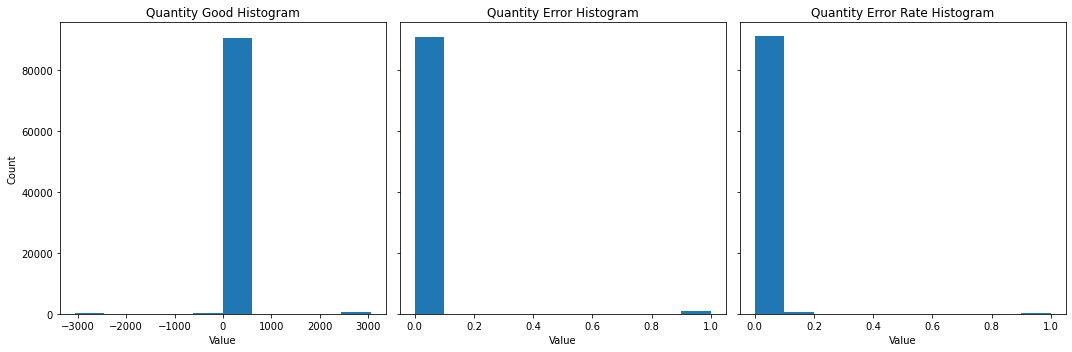

In [13]:
n_bins=10

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15,5))
for i in range(3):
    axs[i].set_xlabel('Value')

axs[0].set_ylabel('Count')
axs[0].hist(df['QTYGOOD'], bins=n_bins)
axs[0].set_title('Quantity Good Histogram')
axs[1].hist(df['QTYERROR'], bins=n_bins)
axs[1].set_title('Quantity Error Histogram')
axs[2].hist(df['ERROR_RATE'], bins=n_bins)
axs[2].set_title('Quantity Error Rate Histogram')
plt.show()

In [14]:
def plotCategory(field):
    items = df[field].value_counts()
    plt.figure(figsize=(15, 5))
    plt.bar(items.keys(), items.values)
    plt.show()

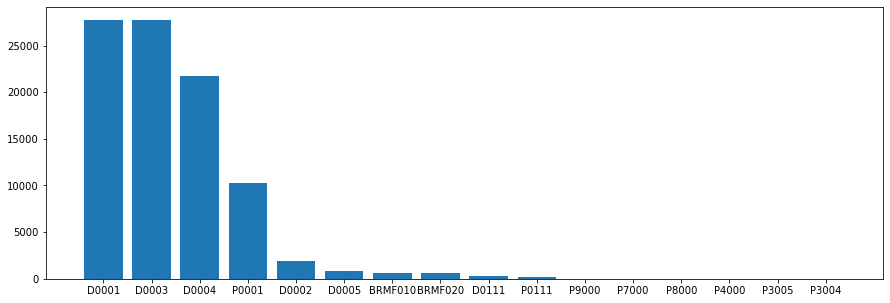

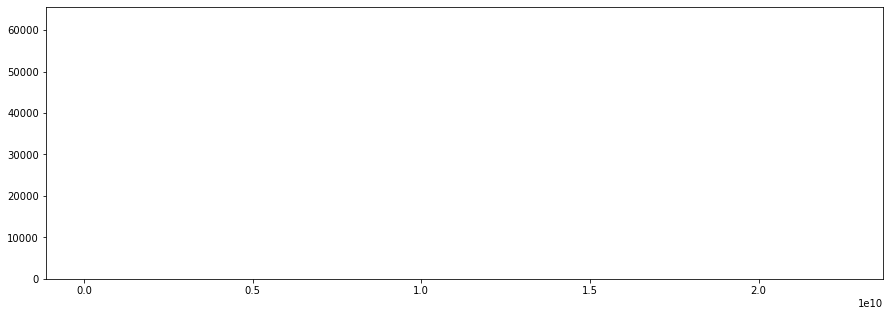

In [15]:
plotCategory('ITEMID')
plotCategory('WORKER')

# preprocessing

In [35]:
features = ['ITEMID', 'OprId', 'WORKER', 'WrkCtrId']
data = df.loc[:, features]
data.loc[:, ('WORKER')] = data['WORKER'].astype(str)
data.loc[:, ('WrkCtrId')] = data['WrkCtrId'].astype(str)
X = data.to_numpy()

enc = preprocessing.OneHotEncoder(handle_unknown='error').fit(X)
X = enc.transform(X).toarray()
Y = df['ERROR_RATE']

In [37]:
X.shape

(91889, 74)

# Training

In [44]:
X_train , X_test , y_train, y_test = train_test_split(X, Y, random_state=0)
regr = svm.SVR()
regr.fit(X_train, y_train)
result = regr.predict(X_test)

(array([22824.,   117.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,    32.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

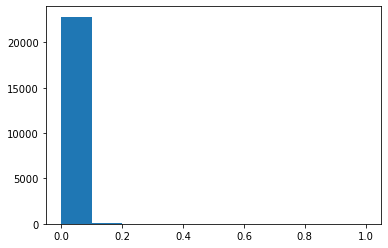

In [75]:
plt.hist(list(y_test))

(array([2269.,    0., 1673.,  349., 4710., 4815., 4468., 2476.,    0.,
        2213.]),
 array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]),
 <BarContainer object of 10 artists>)

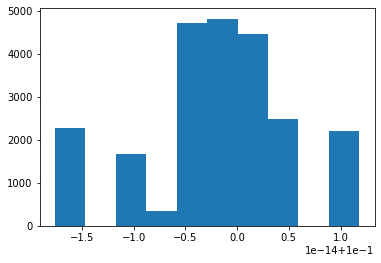

In [76]:
plt.hist(list(result))

In [71]:
df[df.ERROR_RATE != 0].size / df.size * 100

0.8902044858470546